# Ali NN

## Imports and Cuda Device

In [2]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter


%matplotlib inline     
sns.set(color_codes=True)

import gc

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")

## KAN Class

In [4]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Data Import

In [5]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [6]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

KeyboardInterrupt: 

In [ ]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [ ]:
mcf7_smartS_filn["mcf"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["mcf"] = np.zeros_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["mcf"] = np.ones_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["mcf"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

mcf7_smartS_filn["smart"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["smart"] = np.ones_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["smart"] = np.zeros_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["smart"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))

In [ ]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

## Train-Test Split

In [ ]:
datasets_train = {}
datasets_test = {}

for name, dataset in datasets.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_train[name] = train_dataset
    datasets_test[name] = test_dataset

merged_train_dataset = pd.concat(datasets_train.values()).fillna(0).astype(np.int32)
merged_test_dataset = pd.concat(datasets_test.values()).fillna(0).astype(np.int32)

## Free Up Memory #1

In [ ]:
# Free up memory
del dataset_list, dataset_names, datasets, norm_idx_datasets, mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn, mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Define Neural Networks

In [ ]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

In [ ]:
class NNBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNBig, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANBig, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANSmall(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANSmall, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class KANTiny(nn.Module):
    def __init__(self, in_size, H1):
        super(KANTiny, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

## Model Measuring

In [ ]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)

In [ ]:
@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

## Initialize Datasets

In [ ]:
data_loaders_train = {}
data_loaders_test = {}

for name in datasets_train.keys():
    data_loaders_train[name] = DataLoader(NNDataset(datasets_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_test[name] = DataLoader(NNDataset(datasets_test[name], merged_norm_idx), batch_size=32, shuffle=True)

merged_data_loader_train = DataLoader(NNDataset(merged_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_test = DataLoader(NNDataset(merged_test_dataset, merged_norm_idx), batch_size=64, shuffle=True)

## Training Helpers

In [ ]:
def train(model, train_config, writer=None):
    total_epochs = 0
    for config_type, config in train_config:
        if config_type == 0:
            iter_count, subtrain_config = config
            for _ in range(iter_count):
                total_epochs += train(model, subtrain_config, writer)
        elif config_type == 1:
            num_epochs, data_loader, test_loader, optimizer, criterion = config
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs[:, 0], labels)
                    loss.backward()
                    # Clip gradients
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    running_loss += loss.item()

                writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
                measure_model_log(writer, model, test_loader, total_epochs)
                writer.flush()
                total_epochs += 1
        else:
            raise Exception("Invalid training config")
    return total_epochs
        

In [ ]:
#lr_sgd = 1e-2
#lr_ada = 1e-2
#lr_admw = 1e-3
#wd_admw = 1e-4

# Define the optimizer
#sgd = optim.SGD(model.parameters(), lr=lr_sgd)
#adm = optim.Adam(model.parameters(), lr=lr_adm)
#ada = optim.Adagrad(model.parameters(), lr=lr_ada)
#admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

## Training Neural Networks

In [ ]:
input_size = 3002

In [ ]:
model = KANSmall(input_size, 1024, 512, 256).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [ ]:
model

KANSmall(
  (layers): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): Dropout(p=0.5, inplace=False)
    (2): KANLinear(
      (base_activation): SiLU()
    )
    (3): Dropout(p=0.5, inplace=False)
    (4): KANLinear(
      (base_activation): SiLU()
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [ ]:
train_config = [
    [0, [100, 
         [
          [1, [10, list(data_loaders_train.values())[0], list(data_loaders_test.values())[0], ada, bcelogits]],
          [1, [20, list(data_loaders_train.values())[1], list(data_loaders_test.values())[1], ada, bcelogits]],
          [1, [1, list(data_loaders_train.values())[2], list(data_loaders_test.values())[2], ada, bcelogits]],
          [1, [1, list(data_loaders_train.values())[3], list(data_loaders_test.values())[3], ada, bcelogits]]
         ]]]
]

In [ ]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.015122550772503083


 10%|█         | 1/10 [00:00<00:03,  2.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.009511240183201153


 20%|██        | 2/10 [00:00<00:02,  3.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.03307691542431712


 30%|███       | 3/10 [00:00<00:02,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.015135634106115958


 40%|████      | 4/10 [00:01<00:01,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.025094699002354226


 50%|█████     | 5/10 [00:01<00:01,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.007141325728882569


 60%|██████    | 6/10 [00:01<00:01,  3.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.04113454662729055


 70%|███████   | 7/10 [00:02<00:00,  3.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.012820262927561998


 80%|████████  | 8/10 [00:02<00:00,  3.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.05713039077818394


 90%|█████████ | 9/10 [00:02<00:00,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.03123654024057032


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.8036613464355469


  5%|▌         | 1/20 [00:00<00:05,  3.37it/s]

F1 Score: 0.75
Recall: 0.75
Accuracy on test: 72.97297297297297%
Epoch 2, Loss: 1.2296780943870544


 10%|█         | 2/20 [00:00<00:05,  3.43it/s]

F1 Score: 0.782608695652174
Recall: 0.9
Accuracy on test: 72.97297297297297%
Epoch 3, Loss: 0.5243716736634573
F1 Score: 0.75
Recall: 0.9
Accuracy on test: 67.56756756756756%


 15%|█▌        | 3/20 [00:01<00:06,  2.52it/s]

Epoch 4, Loss: 0.674126942952474


 20%|██        | 4/20 [00:01<00:05,  2.83it/s]

F1 Score: 0.7727272727272727
Recall: 0.85
Accuracy on test: 72.97297297297297%
Epoch 5, Loss: 0.9661197165648142


 25%|██▌       | 5/20 [00:01<00:04,  3.02it/s]

F1 Score: 0.76
Recall: 0.95
Accuracy on test: 67.56756756756756%
Epoch 6, Loss: 0.41224366426467896


 30%|███       | 6/20 [00:01<00:04,  3.17it/s]

F1 Score: 0.8695652173913043
Recall: 1.0
Accuracy on test: 83.78378378378379%
Epoch 7, Loss: 0.5612143576145172


 35%|███▌      | 7/20 [00:02<00:04,  3.24it/s]

F1 Score: 0.7916666666666666
Recall: 0.95
Accuracy on test: 72.97297297297297%
Epoch 8, Loss: 0.5536109308401743


 40%|████      | 8/20 [00:02<00:03,  3.32it/s]

F1 Score: 0.8181818181818182
Recall: 0.9
Accuracy on test: 78.37837837837837%
Epoch 9, Loss: 0.6008260448773702


 45%|████▌     | 9/20 [00:02<00:03,  3.37it/s]

F1 Score: 0.782608695652174
Recall: 0.9
Accuracy on test: 72.97297297297297%
Epoch 10, Loss: 0.5430684487024943
F1 Score: 0.9047619047619048
Recall: 0.95
Accuracy on test: 89.1891891891892%


 50%|█████     | 10/20 [00:03<00:03,  3.33it/s]

Epoch 11, Loss: 0.487225204706192


 55%|█████▌    | 11/20 [00:03<00:02,  3.34it/s]

F1 Score: 0.7441860465116279
Recall: 0.8
Accuracy on test: 70.27027027027027%
Epoch 12, Loss: 0.5382890303929647


 60%|██████    | 12/20 [00:03<00:02,  3.39it/s]

F1 Score: 0.8095238095238095
Recall: 0.85
Accuracy on test: 78.37837837837837%
Epoch 13, Loss: 0.36530380447705585


 65%|██████▌   | 13/20 [00:04<00:02,  3.40it/s]

F1 Score: 0.7555555555555555
Recall: 0.85
Accuracy on test: 70.27027027027027%
Epoch 14, Loss: 0.6185088008642197


 70%|███████   | 14/20 [00:04<00:01,  3.39it/s]

F1 Score: 0.7755102040816326
Recall: 0.95
Accuracy on test: 70.27027027027027%
Epoch 15, Loss: 1.3114384214083354


 75%|███████▌  | 15/20 [00:04<00:01,  3.43it/s]

F1 Score: 0.75
Recall: 0.75
Accuracy on test: 72.97297297297297%
Epoch 16, Loss: 0.708897665143013


 80%|████████  | 16/20 [00:04<00:01,  3.42it/s]

F1 Score: 0.8780487804878049
Recall: 0.9
Accuracy on test: 86.48648648648648%
Epoch 17, Loss: 0.7013685603936514


 85%|████████▌ | 17/20 [00:05<00:00,  3.44it/s]

F1 Score: 0.85
Recall: 0.85
Accuracy on test: 83.78378378378379%
Epoch 18, Loss: 0.5531080563863119


 90%|█████████ | 18/20 [00:05<00:00,  3.46it/s]

F1 Score: 0.7727272727272727
Recall: 0.85
Accuracy on test: 72.97297297297297%
Epoch 19, Loss: 1.7925325632095337


 95%|█████████▌| 19/20 [00:05<00:00,  3.50it/s]

F1 Score: 0.9302325581395349
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 20, Loss: 0.3297944863637288


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


F1 Score: 0.9302325581395349
Recall: 1.0
Accuracy on test: 91.8918918918919%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.026282260965940808


100%|██████████| 1/1 [00:13<00:00, 13.22s/it]


F1 Score: 0.9754860524091293
Recall: 0.9768623024830699
Accuracy on test: 97.98890429958391%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.04672904790419599
F1 Score: 0.9602667407613226
Recall: 0.9740698985343855
Accuracy on test: 95.13108614232209%


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.006999706514761783


 10%|█         | 1/10 [00:00<00:02,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.003346281993799494


 20%|██        | 2/10 [00:00<00:02,  3.11it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.04838028596714139


 30%|███       | 3/10 [00:00<00:02,  3.10it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 4, Loss: 0.01132703386247158


 40%|████      | 4/10 [00:01<00:01,  3.05it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 5, Loss: 0.0046639462634630036


 50%|█████     | 5/10 [00:01<00:01,  3.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.07624193816445768


 60%|██████    | 6/10 [00:01<00:01,  3.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.012211567594931694


 70%|███████   | 7/10 [00:02<00:00,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.015506401625316357


 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 9, Loss: 0.10836261563235904


 90%|█████████ | 9/10 [00:02<00:00,  3.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.007009097727000894


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7511746287345886


  5%|▌         | 1/20 [00:00<00:05,  3.48it/s]

F1 Score: 0.8888888888888888
Recall: 1.0
Accuracy on test: 86.48648648648648%
Epoch 2, Loss: 0.8318326075871786


 10%|█         | 2/20 [00:00<00:05,  3.47it/s]

F1 Score: 0.8947368421052632
Recall: 0.85
Accuracy on test: 89.1891891891892%
Epoch 3, Loss: 0.3827045460542043


 15%|█▌        | 3/20 [00:00<00:04,  3.43it/s]

F1 Score: 0.8292682926829268
Recall: 0.85
Accuracy on test: 81.08108108108108%
Epoch 4, Loss: 0.28693392872810364


 20%|██        | 4/20 [00:01<00:04,  3.43it/s]

F1 Score: 0.8717948717948718
Recall: 0.85
Accuracy on test: 86.48648648648648%
Epoch 5, Loss: 0.3614724824825923


 25%|██▌       | 5/20 [00:01<00:04,  3.41it/s]

F1 Score: 0.8648648648648649
Recall: 0.8
Accuracy on test: 86.48648648648648%
Epoch 6, Loss: 0.38567472000916797


 30%|███       | 6/20 [00:01<00:04,  3.42it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 7, Loss: 0.3230297863483429
F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%


 35%|███▌      | 7/20 [00:02<00:03,  3.34it/s]

Epoch 8, Loss: 0.7701622049013773


 40%|████      | 8/20 [00:02<00:03,  3.39it/s]

F1 Score: 0.8333333333333334
Recall: 1.0
Accuracy on test: 78.37837837837837%
Epoch 9, Loss: 0.54154834151268


 45%|████▌     | 9/20 [00:02<00:03,  3.42it/s]

F1 Score: 0.8780487804878049
Recall: 0.9
Accuracy on test: 86.48648648648648%
Epoch 10, Loss: 0.3383573194344838


 50%|█████     | 10/20 [00:02<00:02,  3.44it/s]

F1 Score: 0.8372093023255814
Recall: 0.9
Accuracy on test: 81.08108108108108%
Epoch 11, Loss: 0.26888353129227954


 55%|█████▌    | 11/20 [00:03<00:02,  3.42it/s]

F1 Score: 0.8571428571428571
Recall: 0.9
Accuracy on test: 83.78378378378379%
Epoch 12, Loss: 0.23679080108801523


 60%|██████    | 12/20 [00:03<00:02,  3.43it/s]

F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%
Epoch 13, Loss: 0.12525598208109537
F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%


 65%|██████▌   | 13/20 [00:04<00:02,  2.66it/s]

Epoch 14, Loss: 0.20243577162424722


 70%|███████   | 14/20 [00:04<00:02,  2.87it/s]

F1 Score: 0.8205128205128205
Recall: 0.8
Accuracy on test: 81.08108108108108%
Epoch 15, Loss: 0.13416284571091333


 75%|███████▌  | 15/20 [00:04<00:01,  3.03it/s]

F1 Score: 0.8571428571428571
Recall: 0.9
Accuracy on test: 83.78378378378379%
Epoch 16, Loss: 0.27128679181138676


 80%|████████  | 16/20 [00:04<00:01,  3.14it/s]

F1 Score: 0.9
Recall: 0.9
Accuracy on test: 89.1891891891892%
Epoch 17, Loss: 0.20360774298508963


 85%|████████▌ | 17/20 [00:05<00:00,  3.19it/s]

F1 Score: 0.9047619047619048
Recall: 0.95
Accuracy on test: 89.1891891891892%
Epoch 18, Loss: 0.15721562256415686


 90%|█████████ | 18/20 [00:05<00:00,  3.26it/s]

F1 Score: 0.8292682926829268
Recall: 0.85
Accuracy on test: 81.08108108108108%
Epoch 19, Loss: 0.11185721183816592


 95%|█████████▌| 19/20 [00:05<00:00,  3.31it/s]

F1 Score: 0.8648648648648649
Recall: 0.8
Accuracy on test: 86.48648648648648%
Epoch 20, Loss: 0.3348230570554733


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


F1 Score: 0.8372093023255814
Recall: 0.9
Accuracy on test: 81.08108108108108%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.025175581544438358


100%|██████████| 1/1 [00:13<00:00, 13.20s/it]


F1 Score: 0.9735118199943036
Recall: 0.9644469525959368
Accuracy on test: 97.8502080443828%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.04060272110180686


100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


F1 Score: 0.9623806850084222
Recall: 0.9661781285231116
Accuracy on test: 95.43752128021791%


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0010636204988259124


 10%|█         | 1/10 [00:00<00:02,  3.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.003744303861935805


 20%|██        | 2/10 [00:00<00:02,  3.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.00846767731854925


 30%|███       | 3/10 [00:00<00:02,  3.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.003448992743392054


 40%|████      | 4/10 [00:01<00:01,  3.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.05003619690744188


 50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.0029389605624601245


 60%|██████    | 6/10 [00:01<00:01,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.006528409699234905


 70%|███████   | 7/10 [00:02<00:00,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.011340511962778745


 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0072846925477279


 90%|█████████ | 9/10 [00:02<00:00,  2.99it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 10, Loss: 0.001101976753091094
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.20391559104124704
F1 Score: 0.8444444444444444
Recall: 0.95
Accuracy on test: 81.08108108108108%


  5%|▌         | 1/20 [00:00<00:05,  3.20it/s]

Epoch 2, Loss: 0.16635787983735403


 10%|█         | 2/20 [00:00<00:05,  3.22it/s]

F1 Score: 0.9302325581395349
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 3, Loss: 0.19000878185033798


 15%|█▌        | 3/20 [00:00<00:05,  3.33it/s]

F1 Score: 0.9090909090909091
Recall: 1.0
Accuracy on test: 89.1891891891892%
Epoch 4, Loss: 0.3030946950117747


 20%|██        | 4/20 [00:01<00:04,  3.37it/s]

F1 Score: 0.8888888888888888
Recall: 1.0
Accuracy on test: 86.48648648648648%
Epoch 5, Loss: 0.2987668464581172


 25%|██▌       | 5/20 [00:01<00:04,  3.39it/s]

F1 Score: 0.9047619047619048
Recall: 0.95
Accuracy on test: 89.1891891891892%
Epoch 6, Loss: 0.2249638338883718


 30%|███       | 6/20 [00:01<00:04,  3.44it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.08703622718652089


 35%|███▌      | 7/20 [00:02<00:03,  3.41it/s]

F1 Score: 0.9
Recall: 0.9
Accuracy on test: 89.1891891891892%
Epoch 8, Loss: 0.23663542668024698


 40%|████      | 8/20 [00:02<00:03,  3.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 9, Loss: 0.13435729841391245


 45%|████▌     | 9/20 [00:02<00:03,  3.37it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 10, Loss: 0.08989908794562022


 50%|█████     | 10/20 [00:02<00:02,  3.38it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 11, Loss: 0.12550619492928186
F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%


 55%|█████▌    | 11/20 [00:03<00:03,  2.47it/s]

Epoch 12, Loss: 0.08386587103207906


 60%|██████    | 12/20 [00:03<00:02,  2.68it/s]

F1 Score: 0.8780487804878049
Recall: 0.9
Accuracy on test: 86.48648648648648%
Epoch 13, Loss: 0.08261295408010483


 65%|██████▌   | 13/20 [00:04<00:02,  2.86it/s]

F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%
Epoch 14, Loss: 0.12248314668734868


 70%|███████   | 14/20 [00:04<00:01,  3.00it/s]

F1 Score: 0.8947368421052632
Recall: 0.85
Accuracy on test: 89.1891891891892%
Epoch 15, Loss: 0.11860044673085213


 75%|███████▌  | 15/20 [00:04<00:01,  3.12it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 16, Loss: 0.09783774117628734


 80%|████████  | 16/20 [00:05<00:01,  3.19it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.26605279246966046


 85%|████████▌ | 17/20 [00:05<00:00,  3.26it/s]

F1 Score: 0.9
Recall: 0.9
Accuracy on test: 89.1891891891892%
Epoch 18, Loss: 0.0851149916027983


 90%|█████████ | 18/20 [00:05<00:00,  3.27it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.08322178820768993


 95%|█████████▌| 19/20 [00:05<00:00,  3.32it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.08111623426278432


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.022560449471745323


100%|██████████| 1/1 [00:13<00:00, 13.29s/it]


F1 Score: 0.9712999437253799
Recall: 0.9740406320541761
Accuracy on test: 97.64216366158114%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.03517327727446252


100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


F1 Score: 0.9631936579841449
Recall: 0.9588500563697858
Accuracy on test: 95.57371467483827%


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0144719680538401


 10%|█         | 1/10 [00:00<00:02,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 1.5819407849448908e-05


 20%|██        | 2/10 [00:00<00:02,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.12894898905665286


 30%|███       | 3/10 [00:00<00:02,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.01321726304013282


 40%|████      | 4/10 [00:01<00:01,  3.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.012940500062541105


 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.0031894432924559624


 60%|██████    | 6/10 [00:02<00:01,  2.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.014018109484823071


 70%|███████   | 7/10 [00:02<00:01,  2.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.01140149962157011


 80%|████████  | 8/10 [00:02<00:00,  2.99it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.001798969318679785


 90%|█████████ | 9/10 [00:03<00:00,  2.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.015900530623184767


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.14344684531291327


  5%|▌         | 1/20 [00:00<00:05,  3.52it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 2, Loss: 0.12786544611056647


 10%|█         | 2/20 [00:00<00:05,  3.43it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 3, Loss: 0.05066844945152601


 15%|█▌        | 3/20 [00:00<00:04,  3.43it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 4, Loss: 0.04702132358215749


 20%|██        | 4/20 [00:01<00:04,  3.44it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 5, Loss: 0.04467824209132232


 25%|██▌       | 5/20 [00:01<00:04,  3.38it/s]

F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%
Epoch 6, Loss: 0.052443028738101326


 30%|███       | 6/20 [00:01<00:04,  3.36it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.06975124155481656


 35%|███▌      | 7/20 [00:02<00:03,  3.40it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 8, Loss: 0.19660369803508124


 40%|████      | 8/20 [00:02<00:03,  3.42it/s]

F1 Score: 0.9302325581395349
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 9, Loss: 0.16963224462233484


 45%|████▌     | 9/20 [00:02<00:03,  3.43it/s]

F1 Score: 0.8780487804878049
Recall: 0.9
Accuracy on test: 86.48648648648648%
Epoch 10, Loss: 0.04110128184159597
F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%


 50%|█████     | 10/20 [00:02<00:02,  3.35it/s]

Epoch 11, Loss: 0.04840416740626097
F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%


 55%|█████▌    | 11/20 [00:03<00:02,  3.25it/s]

Epoch 12, Loss: 0.054767975118011236


 60%|██████    | 12/20 [00:03<00:02,  3.28it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 13, Loss: 0.06657814731200536


 65%|██████▌   | 13/20 [00:03<00:02,  3.34it/s]

F1 Score: 0.9302325581395349
Recall: 1.0
Accuracy on test: 91.8918918918919%
Epoch 14, Loss: 0.11346895496050517


 70%|███████   | 14/20 [00:04<00:01,  3.41it/s]

F1 Score: 0.918918918918919
Recall: 0.85
Accuracy on test: 91.8918918918919%
Epoch 15, Loss: 0.14458494385083517
F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%


 75%|███████▌  | 15/20 [00:04<00:02,  2.35it/s]

Epoch 16, Loss: 0.06276996682087581


 80%|████████  | 16/20 [00:05<00:01,  2.59it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 17, Loss: 0.041311021695814056


 85%|████████▌ | 17/20 [00:05<00:01,  2.75it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 18, Loss: 0.07916506690283616


 90%|█████████ | 18/20 [00:05<00:00,  2.92it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.06649923200408618


 95%|█████████▌| 19/20 [00:06<00:00,  3.03it/s]

F1 Score: 0.918918918918919
Recall: 0.85
Accuracy on test: 91.8918918918919%
Epoch 20, Loss: 0.057865727692842484


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.020247954462837028


100%|██████████| 1/1 [00:13<00:00, 13.23s/it]


F1 Score: 0.9724099099099099
Recall: 0.9746049661399548
Accuracy on test: 97.73462783171522%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.026056909635055647


100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


F1 Score: 0.9651685393258427
Recall: 0.9684329199549042
Accuracy on test: 95.77800476676882%


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.010569509118795395


 10%|█         | 1/10 [00:00<00:02,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.0009382568573812478


 20%|██        | 2/10 [00:00<00:02,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.0016375537459772378


 30%|███       | 3/10 [00:00<00:02,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.05541241593300584


 40%|████      | 4/10 [00:01<00:01,  3.01it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.037495155818760395


 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.007846240085655154


 60%|██████    | 6/10 [00:01<00:01,  2.99it/s]

F1 Score: 0.9803921568627451
Recall: 1.0
Accuracy on test: 98.0%
Epoch 7, Loss: 0.003949614897436504


 70%|███████   | 7/10 [00:02<00:00,  3.01it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.002380684076351509


 80%|████████  | 8/10 [00:02<00:00,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.005783751953140934


 90%|█████████ | 9/10 [00:02<00:00,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.027899303589982844


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.09259372639159362


  5%|▌         | 1/20 [00:00<00:05,  3.38it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 2, Loss: 0.046543825498905754


 10%|█         | 2/20 [00:00<00:05,  3.34it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 3, Loss: 0.05862418934702873
F1 Score: 0.9230769230769231
Recall: 0.9
Accuracy on test: 91.8918918918919%


 15%|█▌        | 3/20 [00:00<00:05,  3.22it/s]

Epoch 4, Loss: 0.07287126469115417


 20%|██        | 4/20 [00:01<00:04,  3.25it/s]

F1 Score: 0.8333333333333334
Recall: 0.75
Accuracy on test: 83.78378378378379%
Epoch 5, Loss: 0.27840621396899223


 25%|██▌       | 5/20 [00:01<00:04,  3.34it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 6, Loss: 0.5833626948297024


 30%|███       | 6/20 [00:01<00:04,  3.37it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 7, Loss: 0.04040024864176909


 35%|███▌      | 7/20 [00:02<00:03,  3.40it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 8, Loss: 0.0386396327909703


 40%|████      | 8/20 [00:02<00:03,  3.39it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 9, Loss: 0.041313670575618744


 45%|████▌     | 9/20 [00:02<00:03,  3.39it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 10, Loss: 0.22922030091285706


 50%|█████     | 10/20 [00:02<00:02,  3.42it/s]

F1 Score: 0.9090909090909091
Recall: 1.0
Accuracy on test: 89.1891891891892%
Epoch 11, Loss: 0.07162516750395298


 55%|█████▌    | 11/20 [00:03<00:02,  3.40it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 12, Loss: 0.10615647273759048


 60%|██████    | 12/20 [00:03<00:02,  3.36it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 13, Loss: 0.04350042094786962


 65%|██████▌   | 13/20 [00:03<00:02,  3.38it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 14, Loss: 0.060284327094753586


 70%|███████   | 14/20 [00:04<00:01,  3.41it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 15, Loss: 0.09839418592552344


 75%|███████▌  | 15/20 [00:04<00:01,  3.41it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 16, Loss: 0.036611003801226616


 80%|████████  | 16/20 [00:04<00:01,  3.43it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.04786696409185728


 85%|████████▌ | 17/20 [00:05<00:00,  3.42it/s]

F1 Score: 0.8947368421052632
Recall: 0.85
Accuracy on test: 89.1891891891892%
Epoch 18, Loss: 0.06436343118548393


 90%|█████████ | 18/20 [00:05<00:00,  3.42it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 19, Loss: 0.013737484711329925


 95%|█████████▌| 19/20 [00:05<00:00,  3.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.03285180284486463


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.02117805049636116


100%|██████████| 1/1 [00:13<00:00, 13.21s/it]


F1 Score: 0.97054698457223
Recall: 0.9762979683972912
Accuracy on test: 97.57281553398059%


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0238057587171763


100%|██████████| 1/1 [00:08<00:00,  8.80s/it]


F1 Score: 0.9615812917594655
Recall: 0.9735062006764374
Accuracy on test: 95.30132788559756%


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.001252097306860378


 10%|█         | 1/10 [00:00<00:02,  3.08it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.025242397743795664


 20%|██        | 2/10 [00:00<00:02,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.0068315542303027475


 30%|███       | 3/10 [00:00<00:02,  3.10it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.01925458235201205


 40%|████      | 4/10 [00:01<00:01,  3.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.0036989950237966696


 50%|█████     | 5/10 [00:01<00:01,  3.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.0006407868602513744
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 60%|██████    | 6/10 [00:02<00:02,  1.99it/s]

Epoch 7, Loss: 0.003169838375875811
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 70%|███████   | 7/10 [00:02<00:01,  2.21it/s]

Epoch 8, Loss: 0.44470339613633314


 80%|████████  | 8/10 [00:03<00:00,  2.41it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0017863816030981854


 90%|█████████ | 9/10 [00:03<00:00,  2.59it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 10, Loss: 0.0021027170005254447


100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.40226688732703525


  5%|▌         | 1/20 [00:00<00:05,  3.58it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 2, Loss: 0.10857263067737222


 10%|█         | 2/20 [00:00<00:05,  3.55it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.06391686601758313


 15%|█▌        | 3/20 [00:00<00:04,  3.50it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 4, Loss: 0.010605799034237862


 20%|██        | 4/20 [00:01<00:04,  3.50it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 5, Loss: 0.04862050465483966


 25%|██▌       | 5/20 [00:01<00:04,  3.48it/s]

F1 Score: 0.918918918918919
Recall: 0.85
Accuracy on test: 91.8918918918919%
Epoch 6, Loss: 0.006276867058962428


 30%|███       | 6/20 [00:01<00:04,  3.43it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 7, Loss: 0.032500396793087326


 35%|███▌      | 7/20 [00:02<00:03,  3.41it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 8, Loss: 0.014959206082494347


 40%|████      | 8/20 [00:02<00:03,  3.44it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 9, Loss: 0.017728429685121228


 45%|████▌     | 9/20 [00:02<00:03,  3.44it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.006051287073205458


 50%|█████     | 10/20 [00:02<00:02,  3.42it/s]

F1 Score: 0.95
Recall: 0.95
Accuracy on test: 94.5945945945946%
Epoch 11, Loss: 0.01953115896321833


 55%|█████▌    | 11/20 [00:03<00:02,  3.40it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.015072113660840122


 60%|██████    | 12/20 [00:03<00:02,  3.39it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 13, Loss: 0.0008608641704389205


 65%|██████▌   | 13/20 [00:03<00:02,  3.39it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 14, Loss: 0.050165085742870964
F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%


 70%|███████   | 14/20 [00:04<00:01,  3.33it/s]

Epoch 15, Loss: 0.004095322297265132


 75%|███████▌  | 15/20 [00:04<00:01,  3.32it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 16, Loss: 0.004763435107937185


 80%|████████  | 16/20 [00:04<00:01,  3.36it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.03366747281203667


 85%|████████▌ | 17/20 [00:04<00:00,  3.39it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 18, Loss: 0.008365736066783333


 90%|█████████ | 18/20 [00:05<00:00,  3.40it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.026903154693930748


 95%|█████████▌| 19/20 [00:05<00:00,  3.36it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.02091010908285777


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

F1 Score: 0.9617211511595418
Recall: 0.9585073795600111
Accuracy on test: 96.27210884353742%


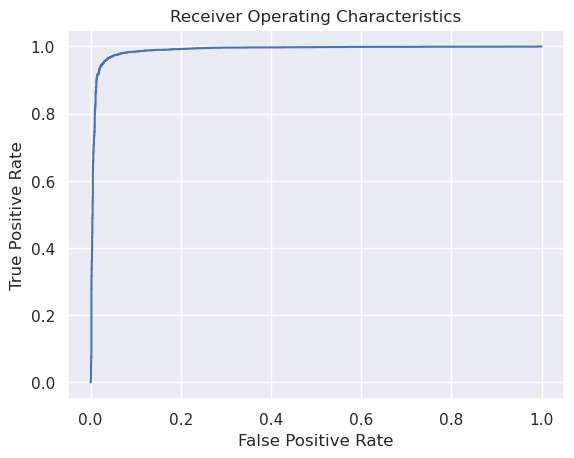

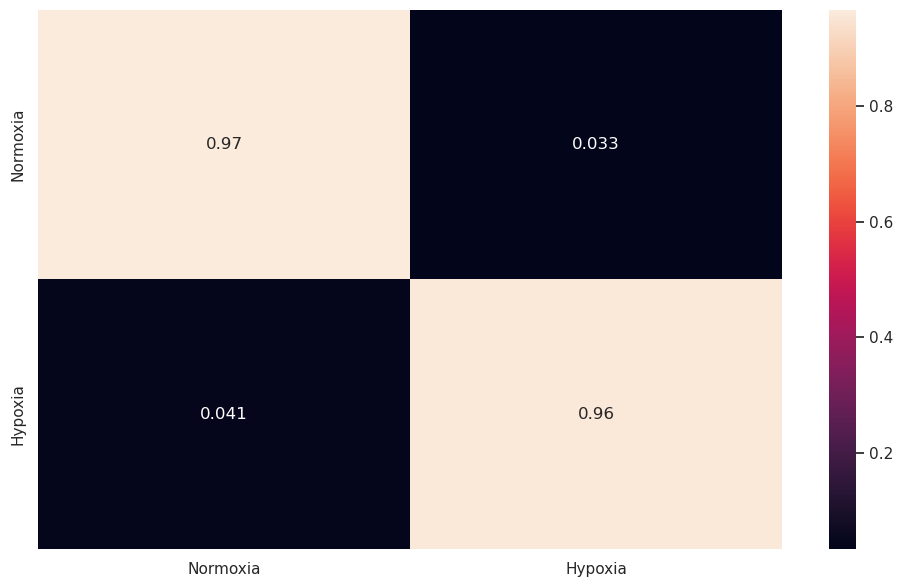

In [31]:
measure_model(model, merged_data_loader_test)

MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
HCC1806_SmartSeq
F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
MCF7_DropSeq
F1 Score: 0.9724099099099099
Recall: 0.9746049661399548
Accuracy on test: 97.73462783171522%
HCC1806_DropSeq
F1 Score: 0.9604456824512535
Recall: 0.971815107102593
Accuracy on test: 95.16513449097718%


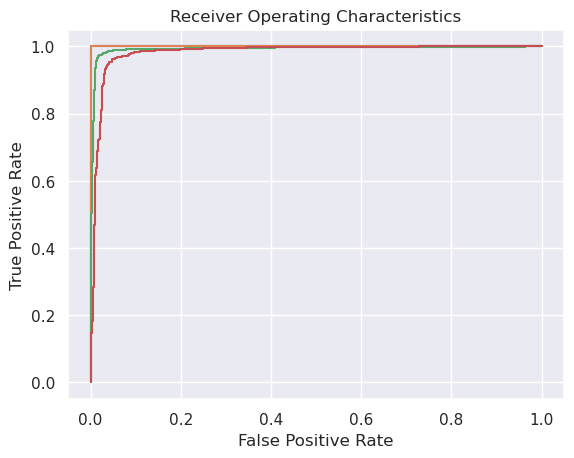

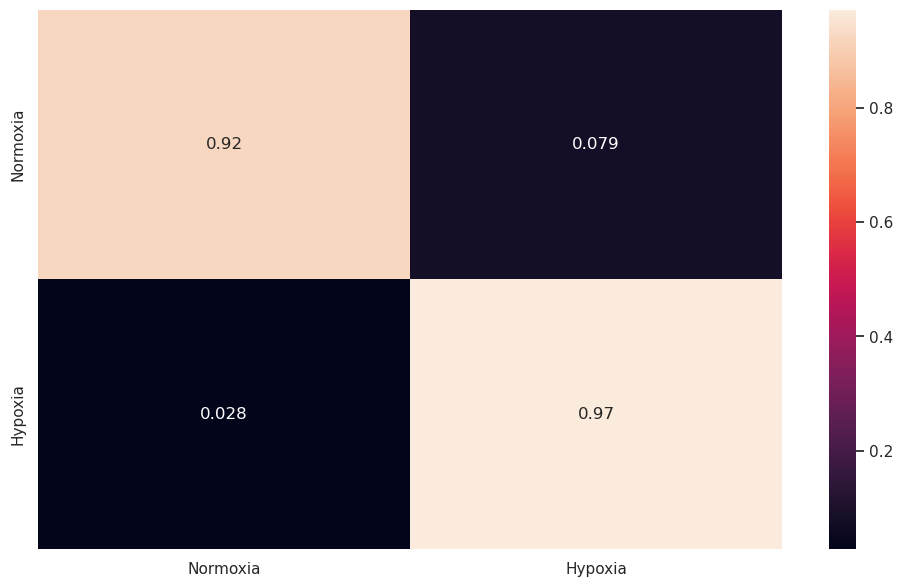

In [55]:
for name, loader in data_loaders_test.items():
    print(name)
    measure_model(model, loader)

In [ ]:

measure_model(model, test_loader_drop)

In [ ]:
torch.save(model.state_dict(), "KAN_SMART_HCC_Smalljdnf.checkpoint")

In [ ]:
import gc

model.cpu()
del model, adm
gc.collect()
torch.cuda.empty_cache()

In [ ]:

from scipy.interpolate import BSpline
def visualize_kan(weight):
    # define B-spline parameters
    grid_size = 5
    spline_order = 3
    weights = weight

    # define knot vector
    knot_vector = np.concatenate(([-1] * spline_order, np.linspace(-1, 1, grid_size), [1] * spline_order))

    # define parameter range
    t = np.linspace(-1, 1, 100)

    # create B-spline object
    spline = BSpline(knot_vector, weights, spline_order)

    # calculate B-spline curve values
    spline_values = spline(t)
    
    # add bias
    silu = nn.SiLU()
    bias = silu(torch.tensor(t))
    
    spline_values = spline_values + bias.numpy()

    # plot B-spline curve
    plt.figure(figsize=(8, 6))
    plt.plot(t, spline_values, label='B-spline curve')
    plt.scatter(np.linspace(-1, 1, len(weights)), weights, color='red', label='Control points')
    plt.title('B-spline Curve')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

for layer in model.cpu().layers:
    if isinstance(layer, KANLinear):
        for i in range(1):
            for j in range(input_size):
                visualize_kan(layer.scaled_spline_weight[i][j].detach().numpy())